In [1]:
#!pip install tf-keras-vis

In [2]:
%reload_ext autoreload
%autoreload 2
 
from matplotlib import pyplot as plt
%matplotlib inline
 
import tensorflow as tf
from tf_keras_vis.utils import num_of_gpus
 
_, gpus = num_of_gpus()
print('Tensorflow recognized {} GPUs'.format(gpus))

2024-05-11 14:27:37.263625: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-11 14:27:37.263669: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-11 14:27:37.264728: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-05-11 14:27:37.270825: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-11 14:27:37.933051: W tensorflow/comp

Tensorflow recognized 1 GPUs


2024-05-11 14:27:38.885639: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1929] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 6795 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 2080, pci bus id: 0000:b3:00.0, compute capability: 7.5


In [3]:
import pennylane as qml
from pennylane import numpy as np
from tensorflow import keras

mnist_dataset = keras.datasets.mnist
(train_images, train_labels), (test_images, test_labels) = mnist_dataset.load_data()

n_epochs = 20   # Number of optimization epochs
n_layers = 1    # Number of random layers
n_train = 200    # Size of the train dataset
n_test = 120     # Size of the test dataset
n_batches = 4     # Size of the batches

# Reduce dataset size
train_images = train_images[:n_train]
train_labels = train_labels[:n_train]
test_images = test_images[:n_test]
test_labels = test_labels[:n_test]

# Normalize pixel values within 0 and 1
train_images = train_images / 255
test_images = test_images / 255

# Add extra dimension for convolution channels
train_images = np.array(train_images[..., tf.newaxis], requires_grad=False)
test_images = np.array(test_images[..., tf.newaxis], requires_grad=False)

n_qubits = 4

dev = qml.device("default.qubit", wires=n_qubits)

@qml.qnode(dev, interface='tf')
def qnotnode(inputs):
    inputs *= np.pi
    # Encoding of 4 classical input values
    qml.AngleEmbedding(inputs, wires=range(n_qubits), rotation='Y')

    # Filter from arxiv.org/abs/2308.14930

    qml.CNOT(wires=[1, 2])
    qml.CNOT(wires=[0, 3])


    # Measurement producing 4 classical output values
    return [qml.expval(qml.PauliZ(j)) for j in range(n_qubits)]

class ConvQLayer(qml.qnn.KerasLayer):
    
    def call(self, inputs):

        out = tf.Variable(tf.zeros((n_batches, 14, 14, n_qubits)))
        for b in range(n_batches):
            # Loop over the coordinates of the top-left pixel of 2X2 squares
            for j in range(0, 28, 2):
                for k in range(0, 28, 2):
                    # Process a squared 2x2 region of the image with a quantum circuit
                    q_results = tf.stack(
                        [
                            inputs[b,j, k, 0],
                            inputs[b,j, k + 1, 0],
                            inputs[b,j + 1, k, 0],
                            inputs[b,j + 1, k + 1, 0]
                        ],
                        axis = 1
                    )
                    q_results = super().call(q_results)
                    # Assign expectation values to different channels of the output pixel (j/2, k/2)
                    for c in range(n_qubits):
                        out[b,j // 2, k // 2, c] = q_results[c]
        return out 

qnotlayer = qml.qnn.KerasLayer(qnotnode, {}, output_dim=[28,28,n_qubits])

qnotlayer.trainable = False

def Qnot_Model():
    """Initializes and returns a custom Keras model
    which is ready to be trained."""
    model = keras.models.Sequential([
        qnotlayer,
        keras.layers.Flatten(),
        keras.layers.Dense(10, activation="softmax")
    ])
    model.compile(
        optimizer='adam',
        loss="sparse_categorical_crossentropy",
        metrics=["accuracy"]
    )
    return model

qnot_model = Qnot_Model()

qnot_history = qnot_model.fit(
    train_images,
    train_labels,
    validation_data=(test_images, test_labels),
    batch_size = n_batches,
    epochs=n_epochs,
    verbose=2
)

11490434/11490434 [==============================] - 1s 0us/step
Epoch 1/20


2024-05-11 14:27:41.694878: I external/local_xla/xla/service/service.cc:168] XLA service 0x6341ecd19820 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-05-11 14:27:41.694912: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 2080, Compute Capability 7.5
2024-05-11 14:27:41.699180: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-05-11 14:27:41.712656: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8904
I0000 00:00:1715437661.827230    4538 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


50/50 - 3s - loss: 3.2705 - accuracy: 0.3150 - val_loss: 1.4725 - val_accuracy: 0.4750 - 3s/epoch - 68ms/step
Epoch 2/20
50/50 - 2s - loss: 0.9360 - accuracy: 0.6900 - val_loss: 1.1045 - val_accuracy: 0.6083 - 2s/epoch - 46ms/step
Epoch 3/20
50/50 - 2s - loss: 0.6410 - accuracy: 0.8250 - val_loss: 1.0775 - val_accuracy: 0.6167 - 2s/epoch - 45ms/step
Epoch 4/20
50/50 - 2s - loss: 0.4874 - accuracy: 0.8600 - val_loss: 1.2501 - val_accuracy: 0.5833 - 2s/epoch - 44ms/step
Epoch 5/20
50/50 - 2s - loss: 0.3475 - accuracy: 0.8950 - val_loss: 1.3494 - val_accuracy: 0.5750 - 2s/epoch - 45ms/step
Epoch 6/20
50/50 - 2s - loss: 0.2969 - accuracy: 0.9050 - val_loss: 1.2580 - val_accuracy: 0.5833 - 2s/epoch - 44ms/step
Epoch 7/20
50/50 - 2s - loss: 0.2005 - accuracy: 0.9400 - val_loss: 0.8112 - val_accuracy: 0.7083 - 2s/epoch - 44ms/step
Epoch 8/20
50/50 - 2s - loss: 0.1719 - accuracy: 0.9550 - val_loss: 1.2976 - val_accuracy: 0.7000 - 2s/epoch - 45ms/step
Epoch 9/20
50/50 - 2s - loss: 0.1924 - accu

In [4]:
model = qnot_model
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (4, 28, 28, 4)            0         
                                                                 
 flatten (Flatten)           (4, 3136)                 0         
                                                                 
 dense (Dense)               (4, 10)                   31370     
                                                                 
Total params: 31370 (122.54 KB)
Trainable params: 31370 (122.54 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [5]:

model2 = keras.Model(model.layers[1].input, model.layers[-1].output)
model2.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(4, 28, 28, 4)]          0         
                                                                 
 flatten (Flatten)           (4, 3136)                 0         
                                                                 
 dense (Dense)               (4, 10)                   31370     
                                                                 
Total params: 31370 (122.54 KB)
Trainable params: 31370 (122.54 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


### Visualize

In [35]:
from tf_keras_vis.activation_maximization import ActivationMaximization
from tf_keras_vis.activation_maximization.callbacks import Progress
from tf_keras_vis.activation_maximization.input_modifiers import Jitter, Rotate2D
from tf_keras_vis.activation_maximization.regularizers import TotalVariation2D, Norm
from tf_keras_vis.utils.model_modifiers import ExtractIntermediateLayer, ReplaceToLinear
from tf_keras_vis.utils.scores import CategoricalScore

# Create the visualization instance.
# All visualization classes accept a model and model-modifier, which, for example,
#     replaces the activation of last layer to linear function so on, in constructor.

image_titles = ['One', 'Two', 'Four', 'Nine']
scores = CategoricalScore([1, 2, 4, 9])

seed_input = tf.random.uniform((4, 28, 28, 4), 0, 255)

activation_maximization = \
   ActivationMaximization(model,
                          model_modifier=[ExtractIntermediateLayer('dense'),
                                          #ReplaceToLinear()
                                          ],
                          clone=False)

# You can use Score class to specify visualizing target you want.
# And add regularizers or input-modifiers as needed.
activations = \
   activation_maximization(scores,
                           steps=300,
                           seed_input=seed_input,
                           input_modifiers=[Jitter(jitter=16), Rotate2D(degree=3)],
                           regularizers=[TotalVariation2D(weight=0.3),
                                         Norm(weight=1, p=1)],
                           optimizer=tf.keras.optimizers.RMSprop(1.0, 0.999),
                           callbacks=[Progress()])

300/300 [==============================] - 25s 84ms/step - Score: 0.0043 - TotalVariation2D: 3.1629 - Norm: 118.6907


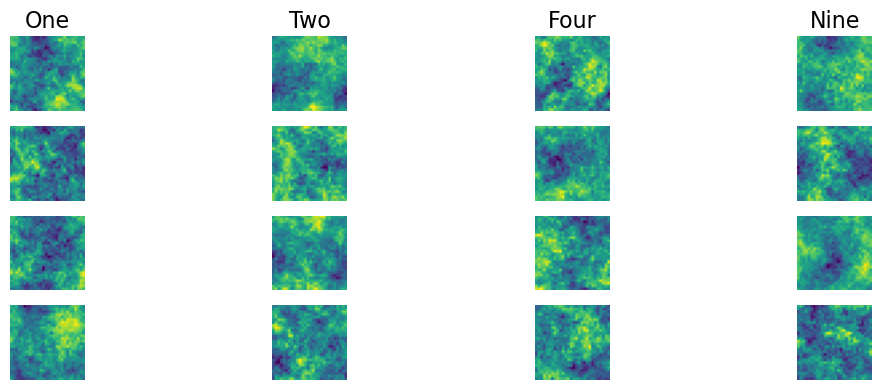

In [36]:

f, ax = plt.subplots(nrows=4, ncols=4, figsize=(12, 4))
for i, title in enumerate(image_titles):
    ax[0, i].set_title(title, fontsize=16)
    ax[0, i].imshow(activations[i,:,:,0])
    ax[0, i].axis('off')
    ax[1, i].imshow(activations[i,:,:,1])
    ax[1, i].axis('off')
    ax[2, i].imshow(activations[i,:,:,2])
    ax[2, i].axis('off')
    ax[3, i].imshow(activations[i,:,:,3])
    ax[3, i].axis('off')
    
plt.tight_layout()
plt.show()

In [43]:
!pip install ipympl

Defaulting to user installation because normal site-packages is not writeable
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 516.3/516.3 kB 3.9 MB/s eta 0:00:00a 0:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.4/139.4 kB 10.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 215.0/215.0 kB 7.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 13.9 MB/s eta 0:00:00a 0:00:01


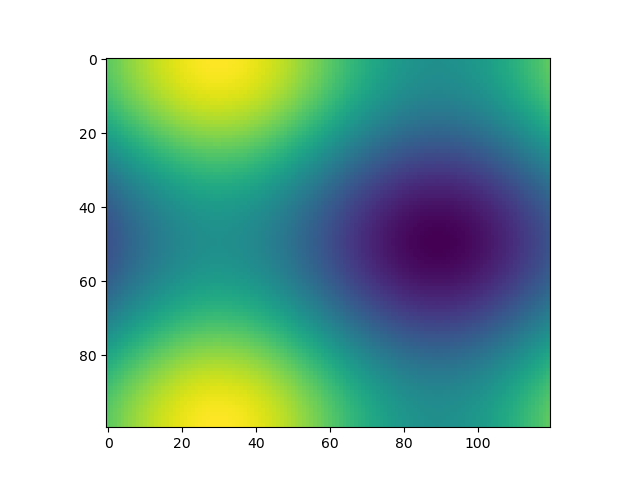

In [1]:
%matplotlib widget

import matplotlib.pyplot as plt
import numpy as np

import matplotlib.animation as animation

fig, ax = plt.subplots()


def f(x, y):
    return np.sin(x) + np.cos(y)

x = np.linspace(0, 2 * np.pi, 120)
y = np.linspace(0, 2 * np.pi, 100).reshape(-1, 1)

# ims is a list of lists, each row is a list of artists to draw in the
# current frame; here we are just animating one artist, the image, in
# each frame
ims = []
for i in range(60):
    x += np.pi / 15
    y += np.pi / 30
    im = ax.imshow(f(x, y), animated=True)
    if i == 0:
        ax.imshow(f(x, y))  # show an initial one first
    ims.append([im])

ani = animation.ArtistAnimation(fig, ims, interval=50, blit=True,
                                repeat_delay=1000)

plt.show()